In [ ]:
!pip install mitiq
!pip install qiskit


     |████████████████████████████████| 112 kB 7.7 MB/s 
     |████████████████████████████████| 1.8 MB 41.3 MB/s 
     |████████████████████████████████| 15.3 MB 168 kB/s 
     |████████████████████████████████| 1.3 MB 49.7 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatib

     |████████████████████████████████| 6.1 MB 5.5 MB/s 
     |████████████████████████████████| 18.0 MB 133 kB/s 
     |████████████████████████████████| 234 kB 66.1 MB/s 
     |████████████████████████████████| 207 kB 74.9 MB/s 
     |████████████████████████████████| 2.1 MB 41.9 MB/s 
     |████████████████████████████████| 199 kB 64.1 MB/s 
     |████████████████████████████████| 635 kB 38.4 MB/s 
     |████████████████████████████████| 1.4 MB 32.9 MB/s 
     |████████████████████████████████| 68 kB 9.1 MB/s 
     |████████████████████████████████| 49 kB 7.6 MB/s 
     |████████████████████████████████| 943 kB 33.0 MB/s 
     |████████████████████████████████| 33.9 MB 18 kB/s 
     |████████████████████████████████| 3.2 MB 32.4 MB/s 
     |████████████████████████████████| 6.3 MB 23.9 MB/s 
  Created wheel for qiskit: filename=qiskit-0.28.0-py3-none-any.whl size=11090 sha256=ba5b2c68851a12e42c21876a63dc87f48e07ff7480bf2ff685aaf56b0b0ea28b
  Stored in directory: /root/.cache/pip/whe

In [ ]:
pip install pylatexenc

     |████████████████████████████████| 162 kB 7.0 MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136835 sha256=3a7a798d1c51b644e093551e863f625d82583b922d951e21f476376754a295cc
  Stored in directory: /root/.cache/pip/wheels/f1/8a/f5/33ee79d4473eb201b519fa40f989b842e373237395a3421f52
Successfully built pylatexenc


In [ ]:
import numpy as np
from scipy.special import erf
import math


from qiskit import *
import qiskit
from qiskit import Aer

from qiskit import execute

from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

from qiskit.tools.visualization import *

from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error
import pandas as pd
from qiskit.test.mock import *
import matplotlib.pyplot as plt
from qiskit.providers.aer import AerSimulator

from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)


from qiskit import pulse
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform, ShiftPhase
from qiskit.pulse.library import drag, GaussianSquare, Drag
from qiskit.visualization import SchedStyle
from qiskit.providers.aer import AerSimulator


import itertools
import mitiq
import argparse
# import cma
import os
import sys
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
import atexit

from qiskit.circuit.gate import Gate
from mitiq import zne 

import warnings
warnings.filterwarnings('ignore')

In [ ]:
mitiq.about()


Mitiq: A Python toolkit for implementing error mitigation on quantum computers
Authored by: Mitiq team, 2020 & later (https://github.com/unitaryfund/mitiq)

Mitiq Version:	0.9.3

Core Dependencies
-----------------
Cirq Version:	0.10.0
NumPy Version:	1.19.5
SciPy Version:	1.4.1

Optional Dependencies
---------------------
PyQuil Version:	Not installed
Qiskit Version:	None
Braket Version:	Not installed

Python Version:	3.7.11
Platform Info:	Linux (x86_64)


In [ ]:
def cx_pulse_instructions(qc: int, qt: int):
    """Retrieve the CNOT pulse schedule for the given
    qubit pair from the backend defaults.
    
    Args:
      qc: control qubit index
      qt: target qubit index
    """
    if [qc, qt] not in backend_config.coupling_map:
        print('Qubit pair has no direct cross resonance!')
    else:
        cx = inst_sched_map.get('cx', qubits=[qc, qt])
        return cx

def Extract_GaussianSquare(q1, q2):
    """Retrieve the Gaussiacross resonance pulse waveform
    for the qubit pair from the cx (CNOT) schedule.
    
    Args:
      q1: control qubit index
      q2: target qubit index
    """
    cx = cx_pulse_instructions(q1, q2)
    cx1 = cx_pulse_instructions(q2, q1)
       
    if cx.instructions[-1][0] < cx1.instructions[-1][0]: # get longer cnot gate pulse schedule 
        cx=cx1
    idx = 0
    Dr_gs = [] # get the gaussiansquare pulse of drive channel
    cr_gs = [] # get the gaussiansquare pulse of control channel
    control_channel='' # get the corresponding control channel for q1 and q2
    Drive_Channel=''    # get the corresponding drive channel with gaussiansquare pulse
    another_Drive_Channel='' # get another drive channel
    
    #look for them
    
    N = 1
    for i in range(len(cx.instructions)):
        if type(cx.instructions[i][1]) is ShiftPhase and type(cx.instructions[i][1].channel) is DriveChannel\
        and cx.instructions[i][1].phase == -math.pi/2 and N == 1 :
            
            another_Drive_Channel=cx.instructions[i][1].channels[0]
            
        if type(cx.instructions[i][1].channels[0]) is ControlChannel and type(cx.instructions[i][1]) is Play\
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            cr_gs.append(cx.instructions[i][1].pulse)

            control_channel=cx.instructions[i][1].channels[0]

        if type(cx.instructions[i][1].channels[0]) is DriveChannel and type(cx.instructions[i][1]) is Play \
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            Dr_gs.append(cx.instructions[i][1].pulse)

            Drive_Channel=cx.instructions[i][1].channels[0]
        if type(cx.instructions[i][1]) is Play:
            N=0

    return control_channel, cr_gs, Drive_Channel, Dr_gs, another_Drive_Channel


def Get_Shift_phase_CRTL_Chan(q1, q2): # When driving channel is phase shifted, the corresponding control channel need to be phase shifted. 
    """Get the driving channels' corresponding control channels
    
    Args:
      q1: qubit
      q2: qubit
    out_put: 
      control_chan1: the corresponding control channel of driving channel with 
    """
    cx1 = cx_pulse_instructions(q1, q2)
    cx2 = cx_pulse_instructions(q2, q1)
    if cx1.instructions[-1][0] > cx2.instructions[-1][0]:
        cx1, cx2 = cx2, cx1
    control_chan0 = []
    control_chan1 = []
    for i in range(len(cx2.instructions)):
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi/2 :
            control_chan0.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi :
            control_chan1.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is Play:
            break

    return control_chan0, control_chan1 

def Rzz_gate_schedule (q0,q1,theta):
    
    uchan, cr_pulse, Dchan, dr_pulse, another_Dchan = Extract_GaussianSquare(q0, q1)
    #Y_chan, X_chan = Get_XY_chan(q0,q1)
    control_chan0, control_chan1 = Get_Shift_phase_CRTL_Chan(q0, q1)
    
    Frac = 2*np.abs(theta)/math.pi
    
    Y_q = Dchan.index
    
    X_q = another_Dchan.index
    
    Y90p = inst_sched_map.get('u2', P0=0, P1=0, qubits=[Y_q]).instructions
    
    X_180 = inst_sched_map.get('x', qubits=[X_q]).instructions[0][1].pulse
    
    ### find out Y_90 pulse 
    
    for Y in Y90p:
        
        if type(Y[1]) is Play:
            
            Y_pulse = Y[1].pulse
            
    ###
            
    drive_samples = Y_pulse.duration # The duration of Y pulse
    
    cr_samples = cr_pulse[0].duration # The duration gaussiansquare pulse
    
    cr_width= cr_pulse[0].width # gaussiansquare pulse's width
    
    cr_sigma = cr_pulse[0].sigma # gaussiansquare pulse's standard error
    
    cr_amp = np.abs(cr_pulse[0].amp)
    
    number_std = (cr_samples-cr_width)/cr_sigma
    
    #Area_g = cr_amp*cr_sigma*np.sqrt(2*np.pi)*erf(number_std) # paper
    
    Area_g = cr_amp*cr_sigma*np.sqrt(2*np.pi)*erf(number_std/2/np.sqrt(2)) #modified
    
    Area_pi_2 = cr_width*cr_amp+Area_g 
    
    dr_sigma = dr_pulse[0].sigma
    
    dr_amp = np.abs(dr_pulse[0].amp)
    
    Area_theta = Frac * Area_pi_2
    
    if Area_theta > Area_g:
        
        New_width = (Area_theta-Area_g)/cr_amp
        
        new_duration = math.ceil((New_width+number_std*cr_sigma)/16)*16
        
        New_width = new_duration-number_std*cr_sigma
        
        cr_pulse[0] = GaussianSquare(duration=new_duration, amp=cr_pulse[0].amp, sigma=cr_sigma, width=New_width)
        
        cr_pulse[1] = GaussianSquare(duration=new_duration, amp=-cr_pulse[0].amp, sigma=cr_sigma, width=New_width)
        
        dr_pulse[0] = GaussianSquare(duration=new_duration, amp=dr_pulse[0].amp, sigma=dr_sigma, width=New_width)
        
        dr_pulse[1] = GaussianSquare(duration=new_duration, amp=-dr_pulse[0].amp, sigma=dr_sigma, width=New_width)
        
        
    else:
        
        New_amp_cr =  cr_pulse[0].amp*Area_theta/Area_g
        
        New_amp_dr= dr_pulse[0].amp*Area_theta/Area_g
        
        new_duration = number_std * cr_sigma
        
        cr_pulse[0] = GaussianSquare(duration=new_duration, amp=cr_amp, sigma=cr_sigma, width=0)
        
        cr_pulse[1] = GaussianSquare(duration=new_duration, amp=-cr_amp, sigma=cr_sigma, width=0)
        
        dr_pulse[0] = GaussianSquare(duration=new_duration, amp=dr_amp, sigma=dr_sigma, width=0)
        
        dr_pulse[1] = GaussianSquare(duration=new_duration, amp=-dr_amp, sigma=dr_sigma, width=0)
        
    # Set up the Rzz schedule
    if theta < 0 :
  
        RZZ_schedule = pulse.Schedule(name="RZZ gate pulse") 
    
        ### Y_-90 pulse
    
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) 
    
        for chan in control_chan1:
            
            RZZ_schedule |= ShiftPhase(-math.pi, chan) 
    
        RZZ_schedule |= Play(Y_pulse, Dchan)
    
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(drive_samples)
    
        for chan in control_chan1: 
        
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(drive_samples)
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], Dchan) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], uchan) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(2*new_duration+2*drive_samples)
    
         ## Y_90 pulse

        RZZ_schedule |= Play(Y_pulse, Dchan) << int(2*new_duration+2*drive_samples)
    
        return RZZ_schedule
    
    else:
        
        RZZ_schedule = pulse.Schedule(name="RZZ gate pulse") 
    
        ### Y_90 pulse
    
    
        RZZ_schedule |= Play(Y_pulse, Dchan)
    
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], Dchan) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], uchan) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(2*new_duration+2*drive_samples)
    
         ## Y_-90 pulse
        
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*new_duration+2*drive_samples)
        
        for chan in control_chan1:
            
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= Play(Y_pulse, Dchan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*new_duration+3*drive_samples)
    
        for chan in control_chan1: 
        
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*new_duration+3*drive_samples)
    
        return RZZ_schedule

In [ ]:
IBMQ.save_account('token',overwrite=True )
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [ ]:
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='iowa-state-uni-1', project='main')

In [ ]:
backend = provider.get_backend('ibmq_casablanca')

# from qiskit.test.mock import FakeVigo

# backend = FakeVigo()

properties = backend.properties()

In [ ]:
backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [ ]:
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

# Post Selection

In [ ]:
def post_selection(bit_str):
    """This function takes in a bitstring, and will return False iff 
    there is a 1 next to another 1 in the given bitstring.
    This does NOT consider a bitstring with 1s on either end as next to one another,
    i.e. given a string of the form '10...01', this function should return False"""
    new_str = '0' + bit_str[0:len(bit_str)]
    for i in range(0,len(bit_str)+1):
        if (new_str[i] == '1') & (new_str[i] == new_str[i-1]):
            return False
    return True

def post_selected_expval(counts, qubit):
    """This function takes in the counts from a circuit execution, as well as a qubit index, 
    and outputs <Z> for that qubit after post-selection"""
    copy_counts = counts.copy()
    
    total = []

    for x in counts.keys():
        if not post_selection(x):
            copy_counts.pop(x)

    for x in copy_counts:
        total.append(copy_counts[x])

    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]

    prob = one_counts / total

    expval = 2*prob - 1
    
    return expval

# Folding Circuits

In [ ]:
#Define the functions used to build the Trotter circuit.
def h_Z(qc,h,dt,qubits_list):
    j=0
    for i in qubits_list:
        if j==0 or j==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        j+=1
        
def X_Rabi(qc,Omega,dt,qubits_list): # Rabi coupling
    
    for i in qubits_list:
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt,qubits_list): # nearest neighbor coupling

    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    qc.rzz(-2*V*dt,q1,q2)
    
    qc.rzz(-2*V*dt,q3,q4)
    
    qc.rzz(-2*V*dt,q0,q1)
    
    qc.rzz(-2*V*dt,q2,q3)

def ZZ_inverse(qc,V,dt,qubits_list): # nearest neighbor coupling

    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    qc.rzz(-2*V*dt,q0,q1)
    
    qc.rzz(-2*V*dt,q2,q3)

    qc.rzz(-2*V*dt,q1,q2)
    
    qc.rzz(-2*V*dt,q3,q4)
    
def ZZ_half(qc,V,dt,qubits_list): # nearest neighbor coupling

    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    qc.rzz(-2*V*dt,q0,q1)
    
    qc.rzz(-2*V*dt,q2,q3)

def Trotter_circuit_5_site_folding_scale1(h,Omega,V,T,n,qubits_list):

    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(backend_config.n_qubits,5)
        
        ### Initial state setting
        
        Trotter_circuit.x(q1)
        
        Trotter_circuit.x(q3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 

            ZZ(Trotter_circuit,V,dt,qubits_list) 

            # Nearest neighbor hopping term

            Trotter_circuit.barrier()
            
        j=0
        
        for i in qubits_list:
            
            Trotter_circuit.measure(i,j)
            
            j+=1

        Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,-2*V*dt), [-2*V*dt]) 
        
        Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,-2*V*dt), [-2*V*dt])

        Trotter_circuit = transpile(Trotter_circuit, backend)
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

def Trotter_circuit_5_site_folding_scale2(h,Omega,V,T,n,qubits_list):

    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(backend_config.n_qubits,5)
        
        ### Initial state setting
        
        Trotter_circuit.x(q1)
        
        Trotter_circuit.x(q3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            Trotter_circuit.barrier()
            
            X_Rabi(Trotter_circuit,-Omega,dt,qubits_list)
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list)
            
            h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 
            
            ZZ(Trotter_circuit,V,dt,qubits_list) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
            ZZ_half(Trotter_circuit,-V,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            Trotter_circuit.barrier() # Z field 
            
            ZZ_half(Trotter_circuit,V,dt,qubits_list)
            
            # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        j=0
        
        for i in qubits_list:
            
            Trotter_circuit.measure(i,j)
            
            j+=1

        Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,-2*V*dt), [-2*V*dt]) 
        
        Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,-2*V*dt), [-2*V*dt])

        Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,2*V*dt), [2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,2*V*dt), [2*V*dt])

        Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,2*V*dt), [2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,2*V*dt), [2*V*dt])

        Trotter_circuit = transpile(Trotter_circuit, backend)
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits
    
def Trotter_circuit_5_site_folding_scale3(h,Omega,V,T,n,qubits_list):

    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(backend_config.n_qubits,5)
        
        ### Initial state setting
        
        Trotter_circuit.x(q1)
        
        Trotter_circuit.x(q3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 
            
            ZZ(Trotter_circuit,V,dt,qubits_list) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
            ZZ_inverse(Trotter_circuit,-V,dt,qubits_list) # Nearest neighbor hopping term
            
            h_Z(Trotter_circuit,-h,dt,qubits_list)
            
            X_Rabi(Trotter_circuit,-Omega,dt,qubits_list)
            
            Trotter_circuit.barrier()
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 
            
            ZZ(Trotter_circuit,V,dt,qubits_list) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        j=0
        
        for i in qubits_list:
            
            Trotter_circuit.measure(i,j)
            
            j+=1

        Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,-2*V*dt), [-2*V*dt]) 
        
        Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,-2*V*dt), [-2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,-2*V*dt), [-2*V*dt])

        Trotter_circuit.add_calibration('rzz', [q0,q1], Rzz_gate_schedule (q0,q1,2*V*dt), [2*V*dt]) 
        
        Trotter_circuit.add_calibration('rzz', [q2,q3], Rzz_gate_schedule (q2,q3,2*V*dt), [2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q1,q2], Rzz_gate_schedule (q1,q2,2*V*dt), [2*V*dt])
        
        Trotter_circuit.add_calibration('rzz', [q3,q4], Rzz_gate_schedule (q3,q4,2*V*dt), [2*V*dt])

        Trotter_circuit = transpile(Trotter_circuit, backend)
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

# Two CNOT gate

In [ ]:
def Trotter_circuit_5_site_no_custom(h,Omega,V,T,n,qubits_list):
    
    q0=qubits_list[0]
    
    q1=qubits_list[1]
    
    q2=qubits_list[2]
    
    q3=qubits_list[3]
    
    q4=qubits_list[4]
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(backend_config.n_qubits,5)
        
        ### Initial state setting
        
        
        Trotter_circuit.x(q1)
        
        Trotter_circuit.x(q3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,qubits_list) # Z field 
            
            #Trotter_circuit.barrier()
            
            ZZ(Trotter_circuit,V,dt,qubits_list) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
        
        j=0
        
        for i in qubits_list:
            
            Trotter_circuit.measure(i,j)
            
            j+=1
        
        Trotter_circuit = transpile(Trotter_circuit, backend) # compile into specific backend
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [ ]:
#Parameters used for the Trotter cirucit
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

#NEED TO CHECK IF THIS IS ALLOWED
delta_t = .5

#CHECK THIS AS WELL
n = int(np.rint(T/delta_t))

NN=n

qubits_list=[2,1,3,5,6]

In [ ]:
#This needs to be 5, since we have 5 qubits in our circuit.
qr = QuantumRegister(backend_config.n_qubits)

# noise_model = NoiseModel.from_backend(backend)

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubits_list, qr=qr, circlabel='mcal')

#qasm_sim = Aer.get_backend('qasm_simulator')

#t_qc = transpile(meas_calibs, backend) #Aer.get_backend('qasm_simulator'))
#qobj = assemble(t_qc, shots=10000)

#note that the noise model isn't used until here. All the code in this cell above this comment is
# simply doing calibration of the circuit.
#cal_results = qasm_sim.run(qobj, shots=10000).result()

shots = 8192

cal_results = execute(meas_calibs, backend, shots=shots)

meas_fitter = CompleteMeasFitter(cal_results.result(), state_labels, circlabel='mcal')

meas_filter = meas_fitter.filter

In [ ]:
Trotter_circuit_no_custom = Trotter_circuit_5_site_no_custom(h,Omega,V,T,n,qubits_list)

Trotter_circuit = Trotter_circuit_5_site_no_custom(h,Omega,V,T,n,qubits_list)

# Zero Noise Extrapolation 

In [ ]:
def TrotterExecutor(backend, shots, post_sel_func, n, qubits_list):
    scale_factors = [1.0, 2.0, 3.0]

    folded_circuits = []

    Trotter_circuit = Trotter_circuit_5_site_folding_scale1(h,Omega,V,T,n,qubits_list)

    Trotter_circuit_scale2 = Trotter_circuit_5_site_folding_scale2(h,Omega,V,T,n,qubits_list)

    Trotter_circuit_scale3 = Trotter_circuit_5_site_folding_scale3(h,Omega,V,T,n,qubits_list)

    #for circuit in circuits:
    #    folded_circuits.append([zne.scaling.fold_gates_at_random(circuit, scale) for scale in scale_factors])
    #folded_circuits = list(itertools.chain(*folded_circuits))

    for i in range(3*n):

        if i % 3 == 0:
            
            folded_circuits.append(Trotter_circuit[i//3])

        elif i % 3 == 1:

            folded_circuits.append(Trotter_circuit_scale2[i//3])

        else:
            
            folded_circuits.append(Trotter_circuit_scale3[i//3])

    #folded_circuits = list(itertools.chain(*folded_circuits))

    job = qiskit.execute(
        experiments=folded_circuits,
        backend=backend,
        optimization_level=0,
        shots=shots
    )
    

    results = job.result()

    if  backend in provider.backends():

      mit_results = meas_filter.apply(results)

    else:

      mit_results = results

    zero_noise_values = {}
    
    for k in range(5):

        expectation_values = []
        
        for t in range(len(folded_circuits)):
            expectation_values.append(post_selected_expval(mit_results.get_counts(t),k))

        zero_noise_values[k] = []
        if isinstance(backend, qiskit.providers.aer.backends.qasm_simulator.QasmSimulator): # exact_sim
            for i in range(len(Trotter_circuit)):
                zero_noise_values[k].append(np.mean(expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))
        else: #device_sim
            fac = mitiq.zne.inference.LinearFactory(scale_factors)
            for i in range(len(Trotter_circuit)):
                zero_noise_values[k].append(fac.extrapolate(scale_factors, 
                expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))

    return zero_noise_values

In [ ]:
il=[0,1,2,3,4,5,6]

Trotter_result_no_custom = execute(Trotter_circuit_no_custom, backend, shots=shots, initial_layout=il)

Trotter_result_sim = execute(Trotter_circuit, Aer.get_backend('qasm_simulator'), shots=shots, initial_layout=il)

In [ ]:

real_device_dict = {}
#ideal_dict = {}

real_device_dict = TrotterExecutor(backend, 8192, post_selection, n, qubits_list)
#ideal_dict = TrotterExecutor(ideal_backend, 8192, post_selection, n, qubits_list)

In [ ]:
results_no_custom = Trotter_result_no_custom.result()

results_sim = Trotter_result_sim.result()

In [ ]:
Sz_nomit = []
Sz_mit_no_custom = []
Sz_sim = []
for i in range(NN):
    tot_mit_no_custom=np.zeros(5)
    tot_sim=np.zeros(5)
    mitigated_counts_no_custom = meas_fitter.filter.apply(results_no_custom).get_counts(i)
    counts_sim = results_sim.get_counts(i)
    for j in range(2**5):
        n=2**5
        if j in mitigated_counts_no_custom.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_mit_no_custom+=(2*np.array(c.join(a).split()).astype(int)-1)*mitigated_counts_no_custom.int_outcomes()[j]
        if j in counts_sim.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*counts_sim.int_outcomes()[j]
    Sz_mit_no_custom.append(tot_mit_no_custom/8192)
    Sz_sim.append(tot_sim/8192)
Sz_mit_no_custom=np.array(Sz_mit_no_custom)
Sz_sim=np.array(Sz_sim)

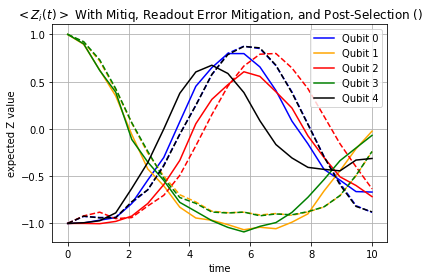

In [ ]:
t=np.linspace(0,TT,NN)

fig,ax = plt.subplots()
ax.plot(t, real_device_dict[0], label='Qubit 0', color = 'blue')
ax.plot(t, Sz_sim[:,0], linestyle = 'dashed', color = 'blue')
ax.plot(t, real_device_dict[1], label='Qubit 1', color = 'orange')
ax.plot(t, Sz_sim[:,1], linestyle = 'dashed', color = 'orange')
ax.plot(t, real_device_dict[2], label='Qubit 2', color = 'red')
ax.plot(t, Sz_sim[:,2], linestyle = 'dashed', color = 'red')
ax.plot(t, real_device_dict[3], label='Qubit 3', color = 'green')
ax.plot(t, Sz_sim[:,3], linestyle = 'dashed', color = 'green')
ax.plot(t, real_device_dict[4], label='Qubit 4', color = 'black')
ax.plot(t, Sz_sim[:,4], linestyle = 'dashed', color = 'black')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("$<Z_i(t)>$ With Mitiq, Readout Error Mitigation, and Post-Selection ()")
ax.legend()
ax.grid()

# Exact Diagonaliztion

In [ ]:
import scipy.linalg as la

def flip(n,i,L): 
    # Flip the i site spin in n-state with system size L
    ii=2**(L-i-1)
    nn=2**L
    if int(bin(n+nn)[3:][i])==1:
        return binaryToDecimal(int(bin(n-ii)[2:]))
    if int(bin(n+nn)[3:][i])==0:
        return binaryToDecimal(int(bin(n+ii)[2:]))


def binaryToDecimal(binary): 
    # change the binary number into decimal number
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal  

def spin_x(i,L):
    n=2**L
    X=np.zeros((n,n))
    for j in range(n):
        X[j,flip(j,i,L)]=1
    return X

def spin_y(i,L):
    n=2**L
    Y=np.zeros((n,n),dtype=complex)
    for j in range(n):
        Y[j,flip(j,i,L)]=1j*(-1)**(int(bin(j+n)[3:][i]))
    return Y

def spin_z(i,L):
    n=2**L
    Z=np.zeros((n,n))
    #a=2**L-1
    for j in range(n):
        Z[j,j]=2*int(bin(j+n)[2:][::-1][i])-1
    return Z

In [ ]:
L=5

Omega=0.2*2
h=2*2 #2*2
V=1*2


H0=0
for i in range(L):
    H0=H0+Omega*spin_x(i,L) # Rabi coupling
    
H1=0
H1=H1+h*spin_z(0,L)/2
H1=H1+h*spin_z(L-1,L)/2
for i in range(L-2):
    H1=H1+h*spin_z(i+1,L) 


V0=0
for i in range(L-1):
    n_f=spin_z((i)%L,L)
    n_b=spin_z((i+1)%L,L)
    V0=V0+V*np.dot(n_f,n_b)


H=H0+H1+V0

In [ ]:
M=H
vals, vecs = la.eigh(M)

inds=np.argsort(vals)
e=vals[inds]
v=vecs[:,inds]

In [ ]:
Nt=20-1
T=10
dt=T/Nt

A=np.eye(len(e))*e
U=np.dot(v,np.dot(np.exp(-1j*A*dt)*np.eye(len(e)),np.conj(np.transpose(v))))

f = 10

wavefunc=np.zeros((len(e),Nt+1),dtype=complex)
n=np.zeros(len(e),dtype=complex)
n[f]=1
wavefunc[:,0]=n
for i in range(Nt):
    wavefunc[:,i+1]=np.dot(U,wavefunc[:,i])

In [ ]:
def Zi_t_p(tf,dt,f,i):
  
  
    Nt=tf/dt
    Nt=int(Nt)

    Zt=spin_z(i,L)
    Zt1=[np.real(np.dot(np.conjugate(wavefunc[:,i]),np.dot(Zt,wavefunc[:,i]))) for i in range(Nt+1)]
    Zt1=np.stack(Zt1,axis=0)
    return Zt1

In [ ]:
Zi=np.zeros((L,Nt+1))
for i in range(L):
    Zi[i,:]=np.real(Zi_t_p(T,dt,f,i))

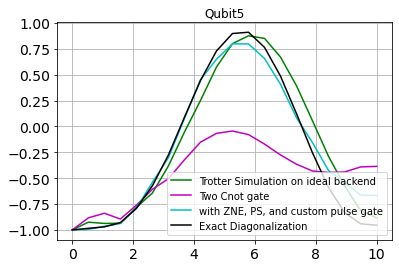

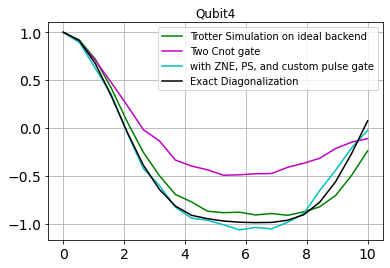

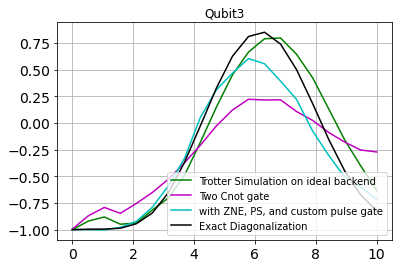

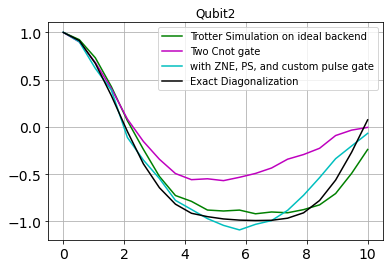

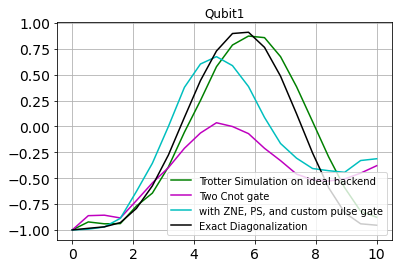

In [31]:
for i in range(5):
    
    t=np.linspace(0,T,NN)
    plt.title("Qubit"+str(5-i))
    plt.plot(t,Sz_sim[:,i],color='g',label='Trotter Simulation on ideal backend')
    plt.plot(t,Sz_mit_no_custom[:,i],color='m',label='Two Cnot gate')
    plt.plot(t,real_device_dict[i],color='c',label='with ZNE, PS, and custom pulse gate')
    plt.plot(t,Zi[i,:],color='k',label='Exact Diagonalization')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()